In [426]:
#Packages##
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import scipy, pylab
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pandas import Series, DataFrame
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
%matplotlib inline
import seaborn; seaborn.set()

In [439]:
##Read Data##
virus_19 = pd.read_csv('COVID-19-geographic-disbtribution-worldwide-2020-03-22.csv', header=0)
virus_19.head()

,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId
0,3/22/20,22,3,2020,0,0,Afghanistan,AF
1,3/21/20,21,3,2020,2,0,Afghanistan,AF
2,3/20/20,20,3,2020,0,0,Afghanistan,AF
3,3/19/20,19,3,2020,0,0,Afghanistan,AF
4,3/18/20,18,3,2020,1,0,Afghanistan,AF


In [440]:
virus_19 = virus_19.drop(["Day", "Month", "Year"], axis=1)
virus_19.head()

,DateRep,Cases,Deaths,Countries and territories,GeoId
0,3/22/20,0,0,Afghanistan,AF
1,3/21/20,2,0,Afghanistan,AF
2,3/20/20,0,0,Afghanistan,AF
3,3/19/20,0,0,Afghanistan,AF
4,3/18/20,1,0,Afghanistan,AF


In [441]:
virus_19 = virus_19.rename(columns={"Countries and territories": "Countries"})
virus_19.head()

,DateRep,Cases,Deaths,Countries,GeoId
0,3/22/20,0,0,Afghanistan,AF
1,3/21/20,2,0,Afghanistan,AF
2,3/20/20,0,0,Afghanistan,AF
3,3/19/20,0,0,Afghanistan,AF
4,3/18/20,1,0,Afghanistan,AF


In [443]:
#Review the Distribution data Cases Confirmed vrs Deaths | Show Detail##
virus_19.describe()

,Cases,Deaths
count,6188.000000,6188.000000
mean,49.333387,2.091467
std,382.698646,21.407641
min,-9.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,0.000000
max,15141.000000,795.000000


In [444]:
#Review type of var##
virus_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6188 entries, 0 to 6187
Data columns (total 5 columns):
DateRep      6188 non-null object
Cases        6188 non-null int64
Deaths       6188 non-null int64
Countries    6188 non-null object
GeoId        6180 non-null object
dtypes: int64(2), object(3)
memory usage: 241.8+ KB


In [445]:
#Print header##
header = virus_19.dtypes.index
print(header)

Index(['DateRep', 'Cases', 'Deaths', 'Countries', 'GeoId'], dtype='object')


In [448]:
virus_total=pd.pivot_table(data=virus_19, index='Countries', values=('Cases', 'Deaths'), aggfunc='sum')
virus_total

,Cases,Deaths
Countries,,
Afghanistan,24,0
Albania,76,2
Algeria,94,10
Andorra,88,0
Angola,2,0
...,...,...
Uzbekistan,33,0
Venezuela,36,0
Vietnam,94,0


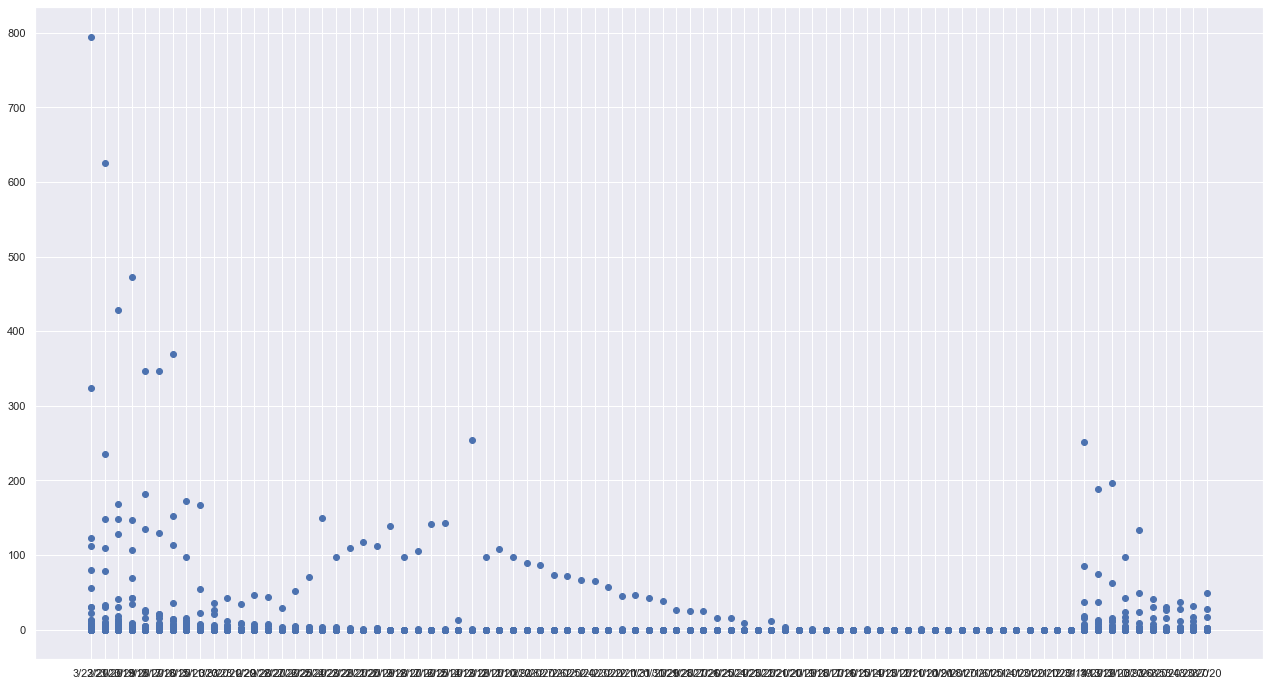

In [449]:
#Exploring Data##
fig, axes = plt.subplots(figsize=(22,12))
x = virus_19['DateRep']
y = virus_19['Deaths']
plt.scatter(x,y)
plt.show()

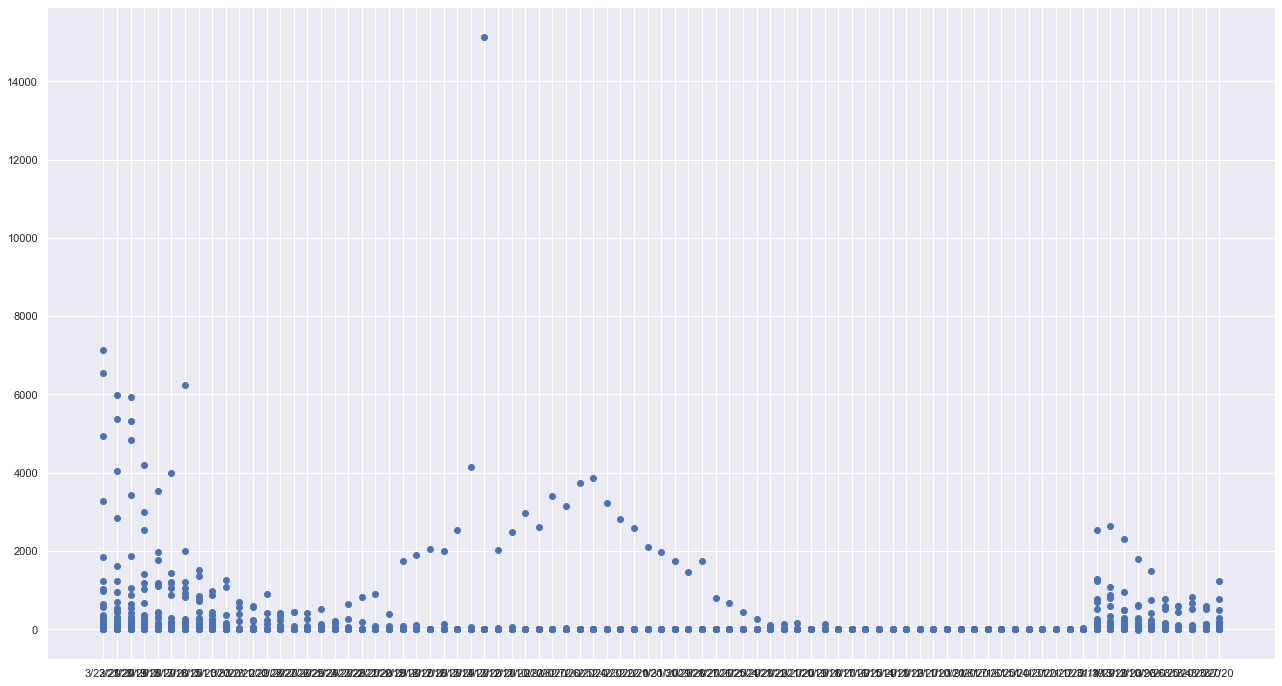

In [450]:
#Exploring Data##
fig, axes = plt.subplots(figsize=(22,12))
x = virus_19['DateRep']
y = virus_19['Cases']
plt.scatter(x,y)
plt.show()

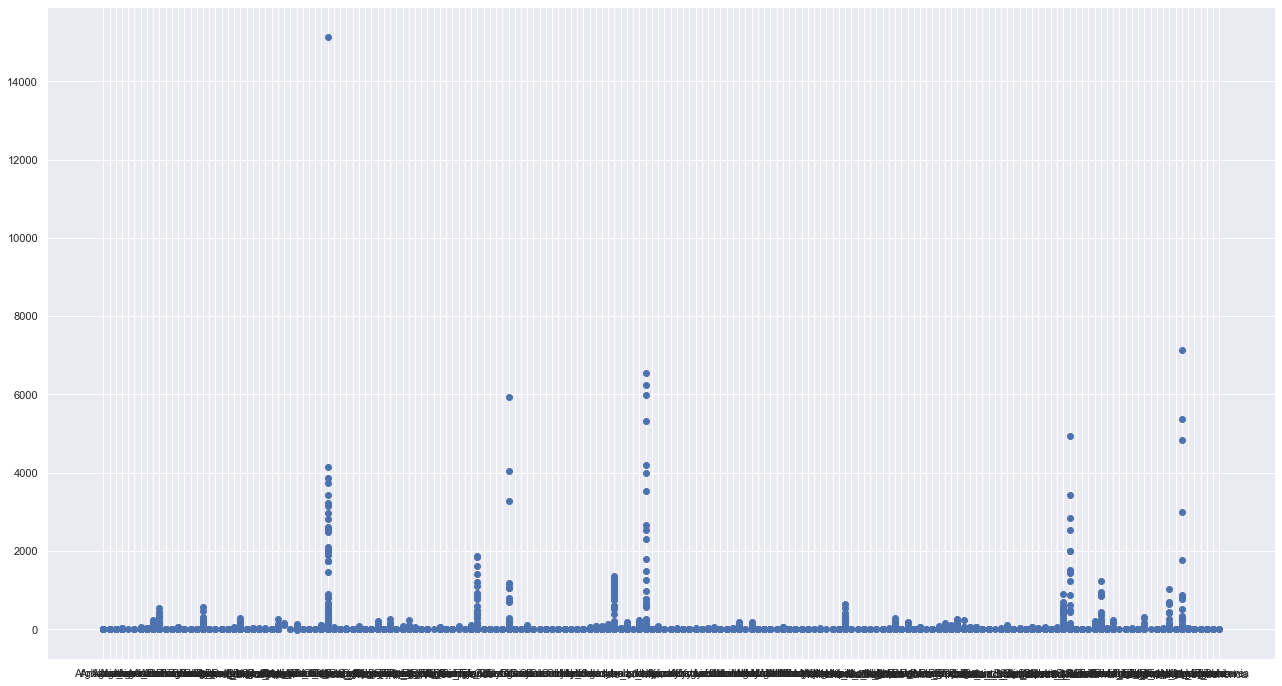

In [451]:
#Exploring Data##
fig, axes = plt.subplots(figsize=(22,12))
x = virus_19['Countries']
y = virus_19['Cases']
plt.scatter(x,y)
plt.show()

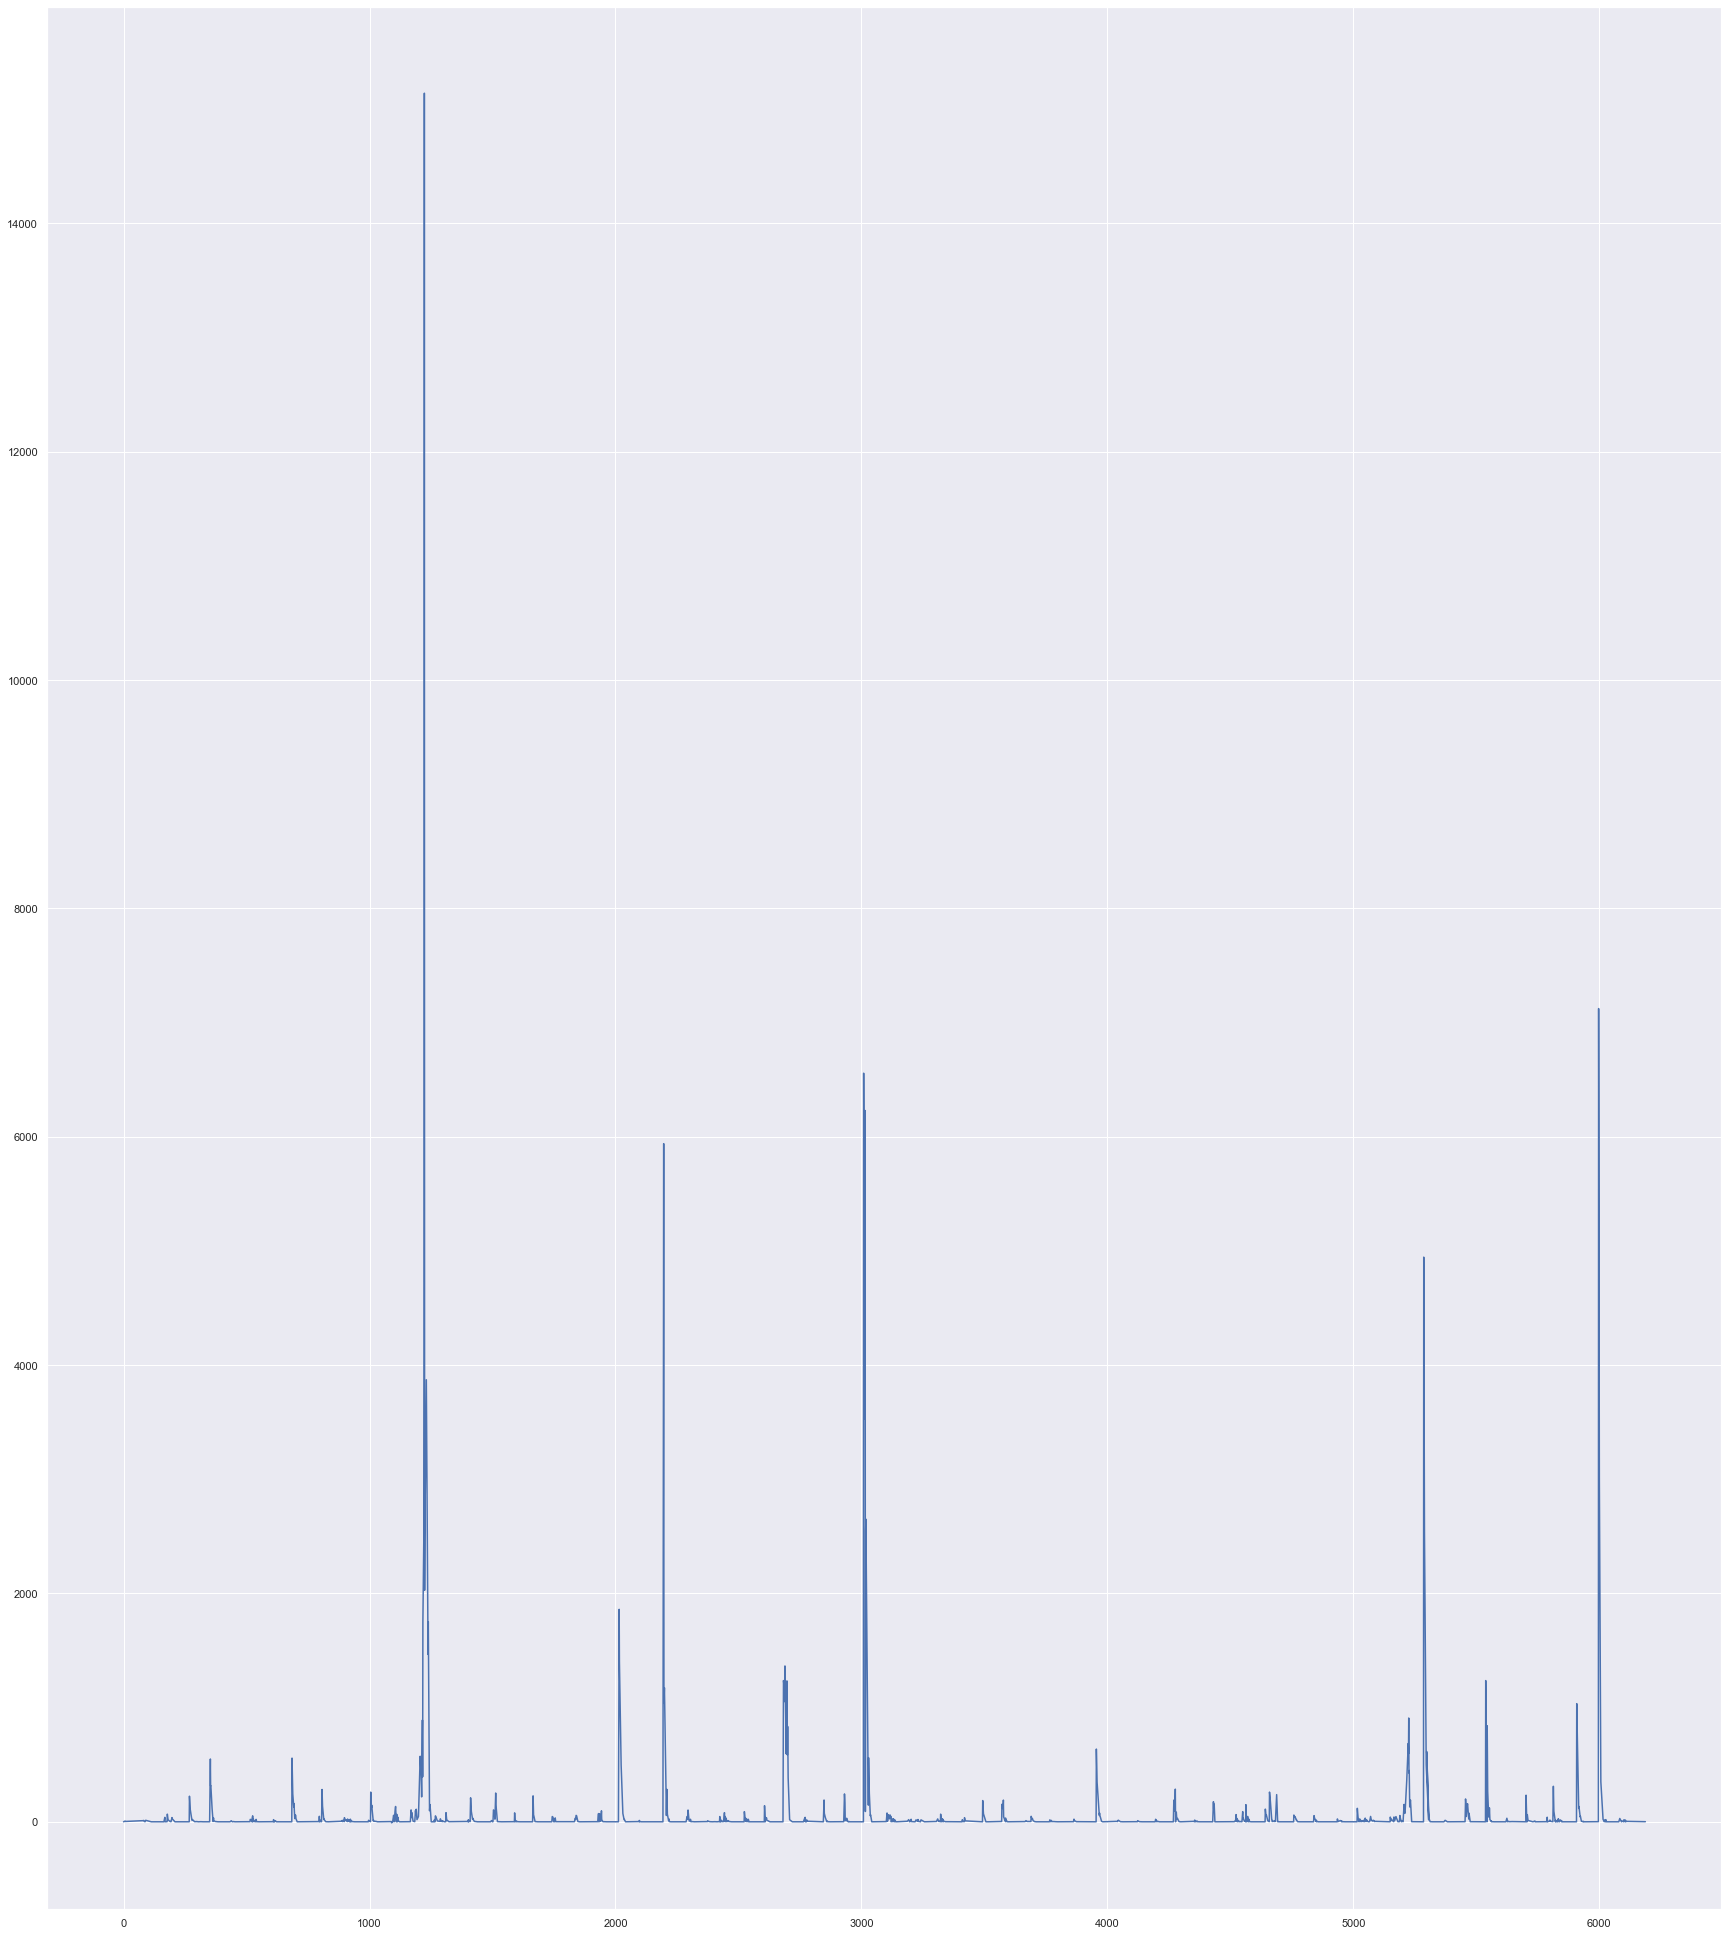

In [452]:
#Exploring Data## | 0= Cases on an international conveyance Japan
fig, axes = plt.subplots(figsize=(30,35))
plt.plot(virus_19['Cases'])
plt.show()

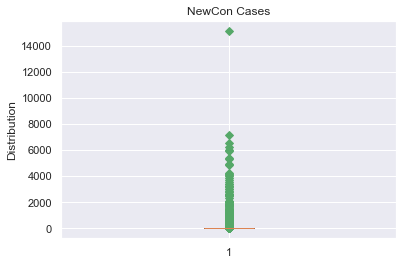

In [453]:
#Exploring Data##
A = virus_19['Cases']
plt.boxplot(A,0,'gD')
plt.title ('NewCon Cases')
plt.ylabel("Distribution")
plt.show()

In [454]:
##*****TIme Series***##
# Validate Nule Data#
virus_19.loc[virus_19['Cases'].isnull()]
# Review odd data : 
virus_19[virus_19['Cases'].isin([np.nan, np.inf, -np.inf])]
virus_19[virus_19['Deaths'].isin([np.nan, np.inf, -np.inf])]
# To convert Date to datetime :
virus_19['DateRep'] = virus_19['DateRep'].astype('datetime64[ns]')
# Replace Nan Data
virus_19['Cases'] = virus_19['Cases'].fillna(0)

In [455]:
virus_19.index = virus_19.DateRep
virus_19 = virus_19.resample('D').mean()

In [456]:
# esto funcionará para rangos de fecha:
virus_19['2019-12-31':'2020-03-15']
# esto funcionará ver datos en un año dado:
virus_19['2020']

,Cases,Deaths
DateRep,,
2020-01-01,0.000000,0.000000
2020-01-02,0.000000,0.000000
2020-01-03,0.253731,0.000000
2020-01-04,0.000000,0.000000
2020-01-05,0.223881,0.000000
...,...,...
2020-03-18,103.873239,5.422535
2020-03-19,123.120805,6.510067
2020-03-20,180.364198,6.432099


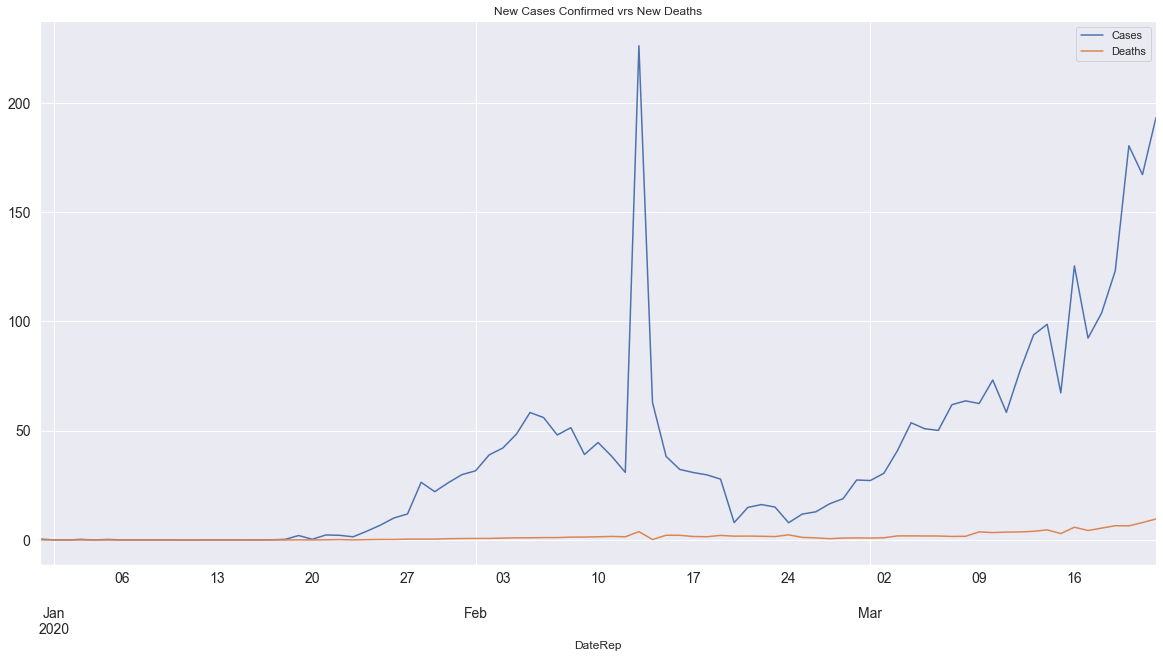

In [457]:
virus_19.plot(figsize=(20,10), title= 'New Cases Confirmed vrs New Deaths', fontsize=14)
plt.show()

In [458]:
##prueba de Dickey-Fuller. evaluar la estacionariedad 
def test_stationarity(timeseries):
    
    # Determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    timeseries = timeseries.iloc[:,0].values
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [459]:
# Transformar el dataframe
ts_log = np.log(virus_19)
# Reemplazar infs con NaN
ts_log.replace([np.inf, -np.inf], np.nan, inplace=True)
# Remover todos los valores NaN
ts_log.dropna(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


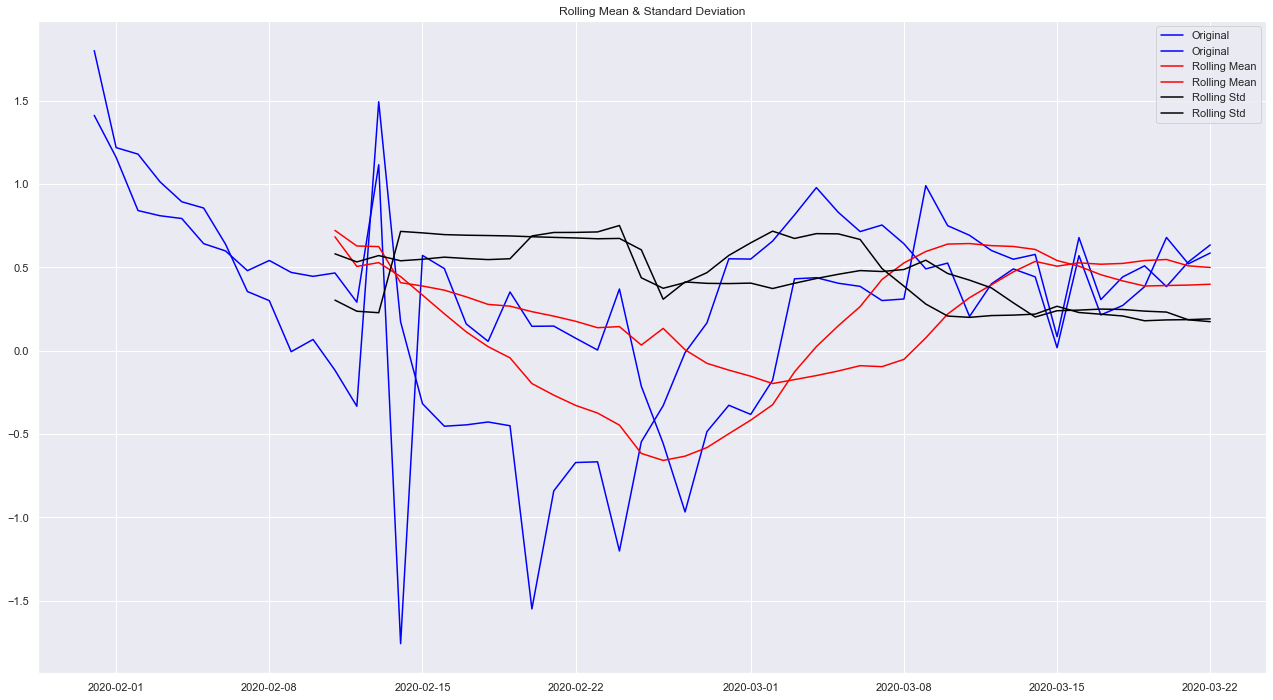

Results of Dickey-Fuller Test:
Test Statistic                 -2.314474
p-value                         0.167342
#Lags Used                      1.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


In [460]:
#Incluso podemos aplicar una técnica de suavizamiento sobre el conjunto de datos transformado para eliminar el ruido que puede estar presente. Una técnica de suavizamiento común es restar la media móvil del conjunto de datos. Con Python podemos lograr esto tan fácil como:
fig, axes = plt.subplots(figsize=(22,12))
# Obtener la media móvil de la serie
moving_avg = ts_log.rolling(12).mean() # 12 meses
# Sustraer la media móvil del dataframe log-transformado
ts_log_moving_avg_diff = ts_log - moving_avg
# Remover valores NaN
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

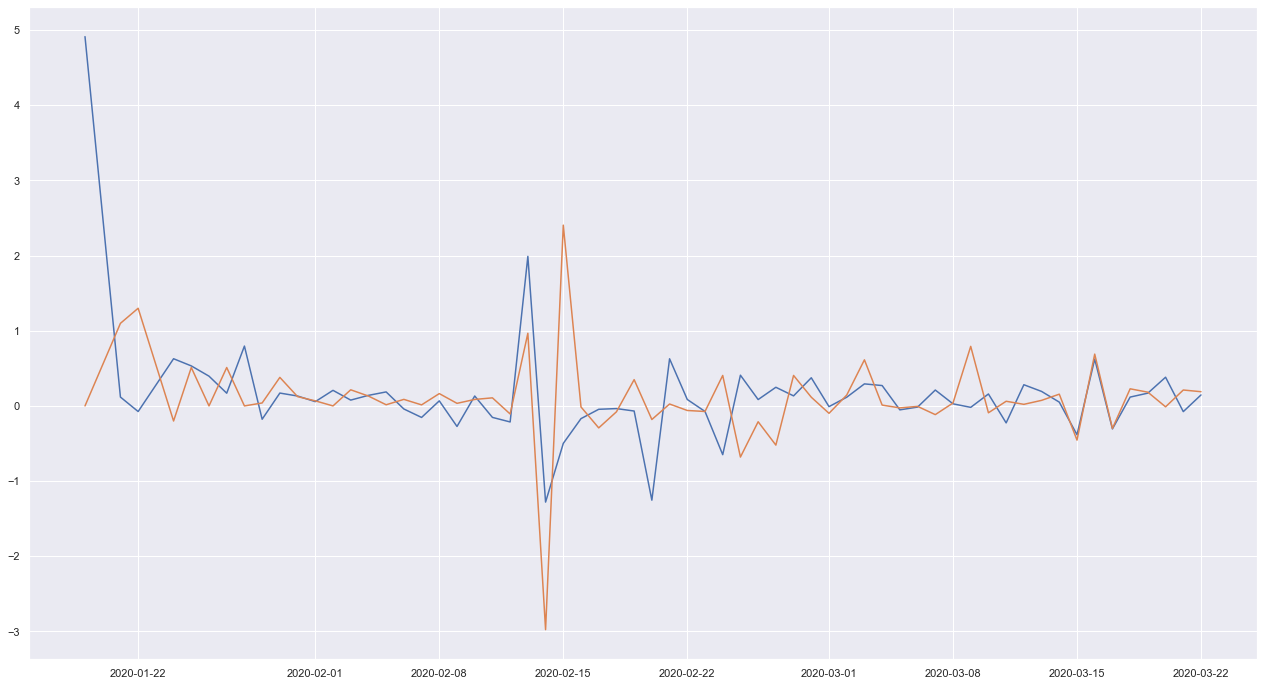

In [461]:
# Suavizamiento: the dataframe the data transformation (seasonality), to avoid the noise
#Average of the series of time
fig, axes = plt.subplots(figsize=(22,12))
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

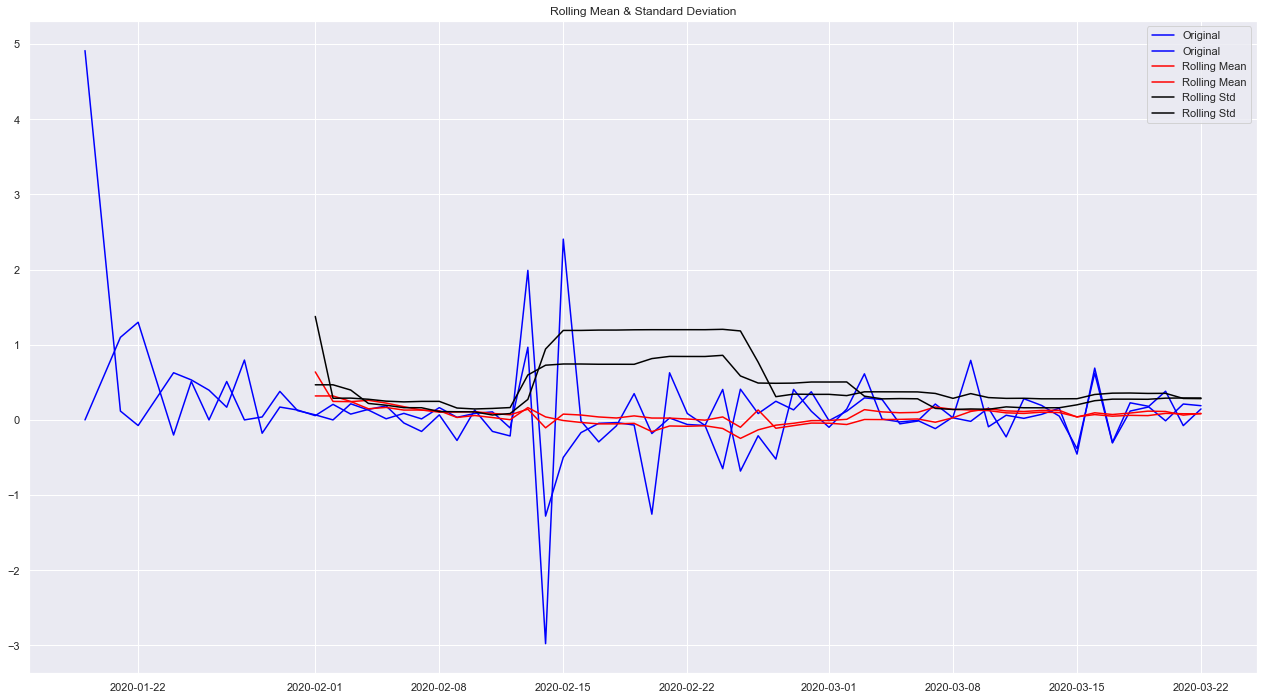

Results of Dickey-Fuller Test:
Test Statistic                -1.459347e+01
p-value                        4.277383e-27
#Lags Used                     0.000000e+00
Number of Observations Used    6.100000e+01
Critical Value (1%)           -3.542413e+00
Critical Value (5%)           -2.910236e+00
Critical Value (10%)          -2.592745e+00
dtype: float64


In [462]:
#“Test Statistic” es significativamente menor que los valores críticos, por lo tanto, esta serie es más estacionaria que la serie original.
fig, axes = plt.subplots(figsize=(22,12))
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

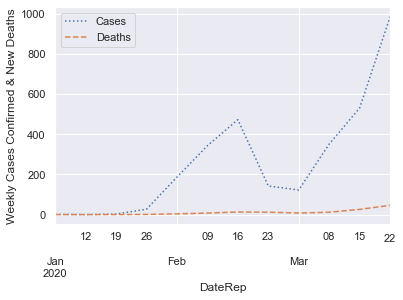

In [463]:
###Resample
weekly = virus_19.resample('W').sum()
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly Cases Confirmed & New Deaths');

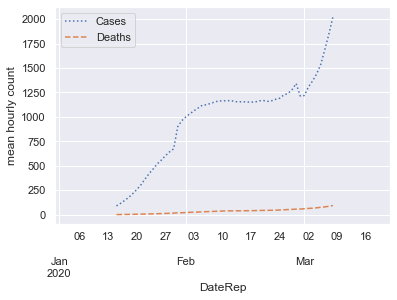

In [464]:
daily = virus_19.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('mean hourly count');

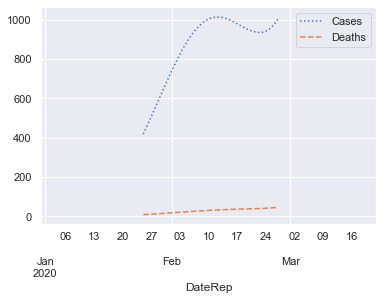

In [465]:
daily.rolling(50, center=True,
              win_type='gaussian').sum(std=10).plot(style=[':', '--', '-']);

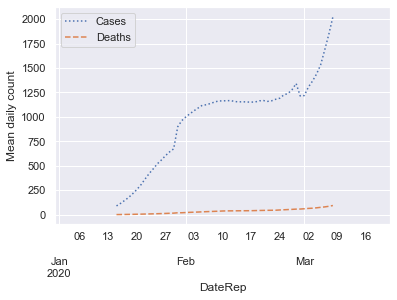

In [466]:
daily = virus_19.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('Mean daily count');

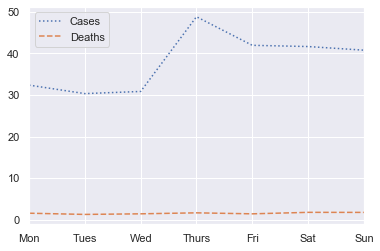

In [467]:
by_weekday = virus_19.groupby(virus_19.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-']);

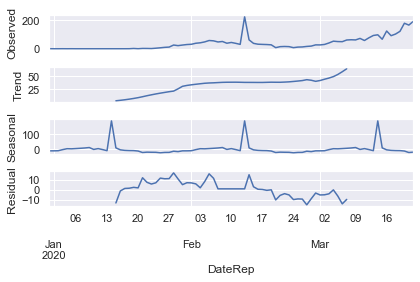

In [468]:
# Cases TIme Series Decomposition
descomposicion = sm.tsa.seasonal_decompose(virus_19['Cases'],
model='additive', freq=30)  
fig = descomposicion.plot()

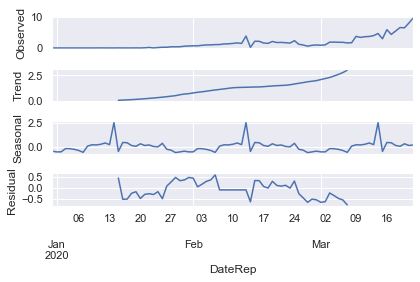

In [472]:
# Deaths TIme Series Decomposition
descomposicion = sm.tsa.seasonal_decompose(virus_19['Deaths'],
model='additive', freq=30)  
fig = descomposicion.plot()

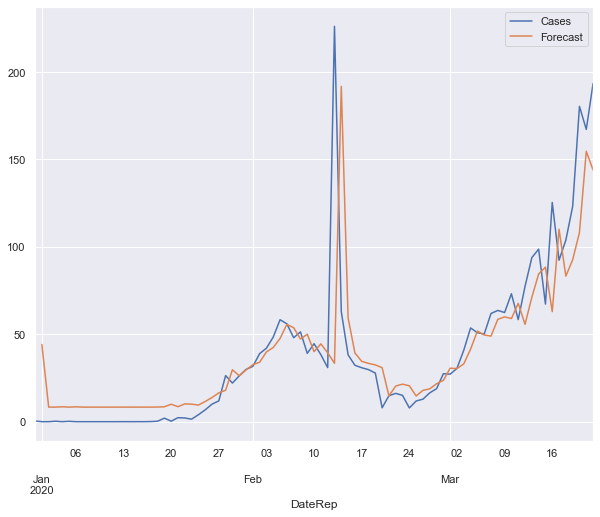

In [469]:
## Cases ARIMA model
modelo = sm.tsa.ARIMA(virus_19['Cases'].iloc[1:], order=(1, 0, 0))  
resultados = modelo.fit(disp=-1)  
virus_19['Forecast'] = resultados.fittedvalues  
plot = virus_19[['Cases', 'Forecast']].plot(figsize=(10, 8)) 

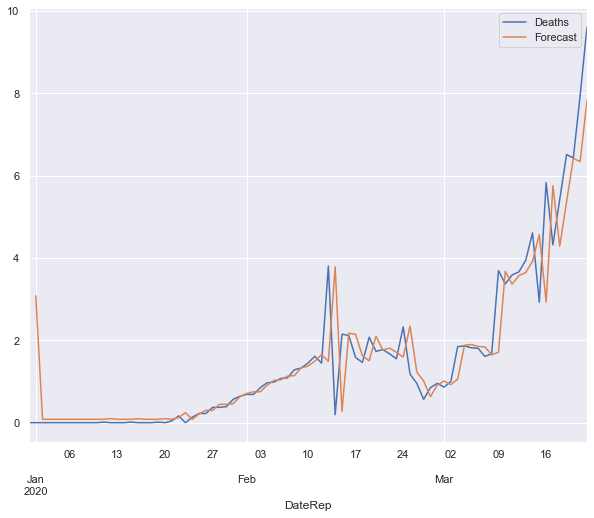

In [475]:
## Cases ARIMA model
modelo = sm.tsa.ARIMA(virus_19['Deaths'].iloc[1:], order=(1, 0, 0))  
resultados_2 = modelo.fit(disp=-1)  
virus_19['Forecast'] = resultados.fittedvalues  
plot = virus_19[['Deaths', 'Forecast']].plot(figsize=(10, 8)) 

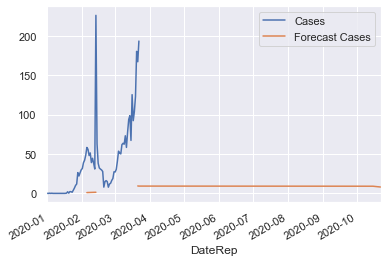

In [474]:
future=virus_19
future=future.reset_index()
mon=future["DateRep"]
mon=mon+pd.DateOffset(months=7)
future_dates = mon[-7-1:]
future = future.set_index('DateRep')
newDf = pd.DataFrame(index=future_dates, columns=future.columns)
future = pd.concat([future,newDf])
future["Forecast Cases"]= resultados.predict(start=35, end =43, dynamic=True)
future["Forecast Cases"].iloc[-10:]=resultados.forecast(steps=10)[0]
future[['Cases','Forecast Cases']].plot()

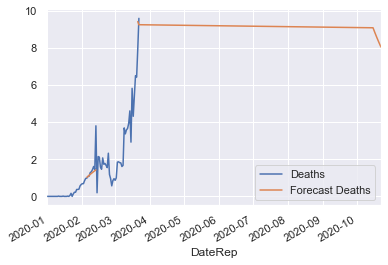

In [477]:
future_2=virus_19
future_2=future_2.reset_index()
mon_2=future_2["DateRep"]
mon_2=mon_2+pd.DateOffset(months=7)
future_2_dates = mon[-7-1:]
future_2 = future_2.set_index('DateRep')
newDf_2 = pd.DataFrame(index=future_2_dates, columns=future_2.columns)
future_2 = pd.concat([future_2,newDf_2])
future_2["Forecast Deaths"]= resultados.predict(start=35, end =43, dynamic=True)
future_2["Forecast Deaths"].iloc[-10:]=resultados_2.forecast(steps=10)[0]
future_2[['Deaths','Forecast Deaths']].plot()